In [2]:
import networkx as nx
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import netwulf
import copy
import community
import seaborn as sns
import pickle as pkl
import seaborn as sns
from matplotlib.colors import Normalize, TwoSlopeNorm

DATA_PATH = 'data/'

# Preprocess the two book dataframes 
- Load dataframes ('https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/home', 'https://github.com/malcolmosh/goodbooks-10k-extended/blob/master/README.md')
- Remove faulty elements of dataframe without the descriptions 
- Remove "additions" to titles in the description dataframes - Example: title (series #1) -> title
- Make a new dataframe that contains "Book ID" (from the dataframe without descriptions), "Book Title" (-||-), "genre" (description dataframe), "description" (description dataframe)
- Store this dataframe

In [ ]:
# Load dataframes
descriptions_df = pd.read_csv(DATA_PATH + "books_descriptions.csv")
book_ID_df = pd.read_json(DATA_PATH + 'goodreads_book_works.json', lines=True)

# Remove columns that are not needed in book_ID_df 
book_ID_df = book_ID_df.filter(items=["best_book_id", "original_title", "reviews_count"])

In [ ]:
# List amount of books are in each dataframe 
print(f"Amount of books in descriptions_df: {len(descriptions_df)}")
print(f"Amount of books in book_ID_df: {len(book_ID_df)}")

In [ ]:
# Remove faulty elements from the book_ID_df
book_ID_df = book_ID_df[book_ID_df['original_title'] != '']

print(f"Amount of books in book_ID_df: {len(book_ID_df)}")

In [ ]:
# Remove faulty elements from the description dataframe
descriptions_df = descriptions_df[descriptions_df['description'].apply(lambda x: isinstance(x, str))]

In [ ]:
# Remove "additions" to titles in the descriptions_df
for i, row in tqdm(descriptions_df.iterrows()):
    original_title = row["title"]
    new_title = re.sub(r'\((.*)', '', original_title)
    descriptions_df.at[i, "title"] = new_title.strip()

In [ ]:
# Lower case all titles to not have confusion in this manner 
descriptions_df['title'] = descriptions_df['title'].str.lower()
book_ID_df['original_title'] = book_ID_df['original_title'].str.lower()

# Louvain, Modularity, Confusion matrices

In [5]:
shelf_edges = np.load(DATA_PATH + 'shelf_edges.npy',allow_pickle = True)

In [6]:
G = nx.Graph()

# Iterate over the items in the dictionary and add edges with weights
for nodes, weight in test_edges.items():
    if weight > 0:
        node_1, node_2 = nodes
        G.add_edge(node_1, node_2, weight=weight)

In [ ]:
# Find corresponding indexes to merge the dataframes
titles_not_found = []
book_df = pd.DataFrame(columns=['book_id', 'title', 'description', 'genres'])

for i, row in tqdm(descriptions_df.iterrows()):
    title = row['title']
    # Check if the title is in book_ID_df, else append it to the titles_not_found list
    if title in book_ID_df['original_title'].values:
        # Get all rows that have the a matching title as the current row
        temp_df = book_ID_df[book_ID_df['original_title'] == title]
        
        # Get the book id of the book  with the highest amount of reviews
        book_id = temp_df['best_book_id'][temp_df['reviews_count'].idxmax()]
        descriptions = row['description']
        genres = row['genres']
        book_df = book_df.append({'book_id': book_id, 'title': title, 'description': descriptions, 'genres': genres}, ignore_index=True)
    else: 
        titles_not_found.append(title)

# print the amount of elements that are not found
print(f"Out of the 10000 titles {len(titles_not_found)} are not found in the book_ID_df")

In [ ]:
# Somehow the same book appears multiple times, hence we drop the duplicates
book_df.drop_duplicates(subset=['title'], inplace=True)

In [ ]:
# Save book_df to a csv 
book_df.to_csv(DATA_PATH + 'book_df.csv', index=False)

# Preprocess the shelves 
- Use "book_id_map.csv" to find the books we use (ids) and store "new_ids" (the ids we can use to find the relevant shelfs)
- Drop all rows in "goodreads_interactions.csv" that have different ids than "new_ids". 
- Store this dataset.  

In [ ]:
# Load dataframes
book_id_map_df = pd.read_csv(DATA_PATH + "book_id_map.csv")
book_df = pd.read_csv(DATA_PATH + "book_df.csv")

In [ ]:
# Create map from book_id to book_id_csv
book_id_map = {book_id_map_df['book_id'][i]: book_id_map_df['book_id_csv'][i] for i in range(len(book_id_map_df))}

# Change the book ID in our dataset to match the shelf dataset
remove_list = [] # remove about 15 books that are for inexplicable reasons not in the shelf dataset
for i in range(len(book_df)):
    try:
        book_df["book_id"][i] = book_id_map[book_df["book_id"][i]]
    except:
        remove_list.append(i)
print(f"Out of {i} books {len(remove_list)} are not in the shelf dataset and hence removed")
book_df.drop(remove_list, inplace=True)

# Save the book_df dataframe with the index change 
book_df.to_csv(DATA_PATH + 'book_matching_ids_df.csv', index=False)


In [ ]:
my_list = book_df["book_id"].to_list()


In [ ]:
# Load the shelves dataframe (this takes some time and memory)
shelves_df = pd.read_csv(DATA_PATH + "goodreads_interactions.csv")

# Check how many books are on the shelves of ALL users combined 
len(shelves_df)

In [ ]:
# Remove books on the shelves that are not in the book_df
shelves_df = shelves_df[shelves_df['book_id'].isin(book_df['book_id'].tolist())]

# Save the new shelves_df 
shelves_df.to_csv(DATA_PATH + 'shelves_df.csv', index=False)

# Check how many books are on the shelves of ALL users combined - after removal of books not in book_df
print(f"We have {len(shelves_df)} shelves in total, and in these there are {len(set(shelves_df['book_id'].tolist()))} unique books.")

### Louvain

In [8]:
# Function that applies the Louvain algorithm to a grap, and returns communities
def louvain_communities(graph):
    # Use the louvain method to find communities
    partition = community.best_partition(graph) # community function that uses Louvain-algorithm
    
    # Reformat the partitioning
    communities = {}
    for node, community_id in partition.items():
        if community_id in communities:
            communities[community_id].append(node)
        else:
            communities[community_id] = [node]
    
    return list(communities.values())

def louvain_communities_faster(graph):
    # Use the louvain method to find communities
    partition = community.best_partition(graph) # community function that uses Louvain-algorithm
    
    # Reformat the partitioning
    communities = {}
    for node, community_id in tqdm(partition.items()):
        communities.setdefault(community_id, []).append(node)
    
    return list(communities.values())

In [7]:
res = louvain_communities_faster(shelf_edges) # This took 1 hour to run with test dataset

### Modularity

In [13]:
#Modularity function
def modularity(G, communities):
    """
    Compute the modularity for a communities of a graph.

    Parameters:
        - G: the NetworkX graph
        - communities (list): a list of communities, where each community is a list of node IDs

    Returns:
        - M: the modularity value for the graph
    """
    
    total_links = G.number_of_edges()
    num_of_communities = len(communities)
    links_in_community = {community: 0 for community in range(num_of_communities)}
    tot_degree = {community: 0 for community in range(num_of_communities)}
    
    # Dictionary to map node IDs to community IDs
    communities_lookup = {node: community for community, nodes in enumerate(communities) for node in nodes}

    # Count the number of links within each community and the total degree of each community
    for (node_1, node_2) in G.edges():
        node_1_community = communities_lookup[node_1]
        node_2_community = communities_lookup[node_2]
        
        # Since we go through all edges, we also get the degree of all nodes
        tot_degree[node_1_community] += 1
        tot_degree[node_2_community] += 1
        
        # If the nodes are in the same community, add one to that community's link count
        if node_1_community == node_2_community:
            links_in_community[node_1_community] += 1

    # Compute the modularity
    M = 0.0
    for i in range(num_of_communities):
        M += (links_in_community[i] / total_links) - ((tot_degree[i] / (2 * total_links)) ** 2)

    return M

def modularity_faster(G, communities):
    """
    Compute the modularity for a communities of a graph.

    Parameters:
        - G: the NetworkX graph
        - communities (list): a list of communities, where each community is a list of node IDs

    Returns:
        - M: the modularity value for the graph
    """
    
    total_links = G.number_of_edges()
    num_of_communities = len(communities)
    links_in_community = [0] * num_of_communities
    tot_degree = [0] * num_of_communities
    nodes_in_community = [set(c) for c in communities]

    # Compute the total degree of nodes in each community
    for node, community in enumerate(nodes_in_community):
        community_edges = G.subgraph(community).edges()
        community_degree = sum([G.degree(n) for n in community])
        tot_degree[node] = community_degree
        for n1, n2 in community_edges:
            if n1 in community and n2 in community:
                links_in_community[node] += 1

    # Compute the modularity
    M = 0.0
    for i in range(num_of_communities):
        M += (links_in_community[i] / total_links) - ((tot_degree[i] / (2 * total_links)) ** 2)

    return M

def modularity_nx(G, communities):
    """
    Compute the modularity for a communities of a graph.

    Parameters:
        - G: the NetworkX graph
        - communities (list): a list of communities, where each community is a list of node IDs

    Returns:
        - M: the modularity value for the graph
    """

    # Use the louvain method to find communities
    partition = {node: community_id for community_id, nodes in enumerate(communities) for node in nodes}

    # Compute the modularity
    M = community.modularity(partition, G)

    return M


In [14]:
mod = modularity_nx(G,res) #Took four minutes

In [15]:
mod_2 = modularity_faster(G,res) # Took two minutes

### Confusion Matrix

In [3]:
from collections import defaultdict

In [4]:
def create_matching_matrix(graph1, graph2):
    graph1_groups = list(set(graph1.values()))
    graph2_groups = list(set(graph2.values()))

    matrix = defaultdict(lambda: defaultdict(int))
    for group1 in graph1_groups:
        for group2 in graph2_groups:
            matrix[group1][group2] = 0

    for book_id, group1 in graph1.items():
        group2 = graph2.get(book_id)
        if group2 is not None:
            matrix[group1][group2] += 1

    df = pd.DataFrame(matrix).T.fillna(0)
    return df

In [14]:
def plot_matching_matrix(matching_matrix, title='Matching Matrix', xlabel=None, ylabel=None,size_title = 20):
    n_columns = len(matching_matrix.columns)

    # Sort rows by their sum in descending order
    matching_matrix = matching_matrix.loc[matching_matrix.sum(axis=1).sort_values(ascending=False).index]

    # Adjust the figsize to create square cells
    fig, ax = plt.subplots(figsize=(n_columns, n_columns))

    sns.set(font_scale=1.2, rc={"axes.grid": False})

    cmap = sns.color_palette("rocket_r", as_cmap=True)

    image_data = np.zeros((len(matching_matrix), n_columns, 4))

    for i, (col_name, col_data) in enumerate(matching_matrix.iteritems()):
        # Change the vmax to the sum of all the numbers in the column
        norm = TwoSlopeNorm(vmin=0, vcenter=col_data.mean(), vmax=col_data.sum())

        image_data[:, i] = cmap(norm(col_data.values))[:, :4]

        for y, value in enumerate(col_data):
            ax.text(i, y, f'{value:.0f}', ha='center', va='center', color='black' if norm(value) < 0.5 else 'white',fontsize = 30)

    # Set the aspect ratio to 1
    ax.imshow(image_data, aspect=1, interpolation='nearest')

    ax.set_xticks(range(n_columns))
    ax.set_xticklabels(matching_matrix.columns)
    ax.set_yticks(range(len(matching_matrix)))
    ax.set_yticklabels(matching_matrix.index)
    
    # Set the custom title, x-axis label, and y-axis label
    ax.set_title(title,fontsize = size_title)
    ax.set_xlabel(xlabel,fontsize = size_title)
    ax.set_ylabel(ylabel,fontsize = size_title)

    fig.tight_layout()
    plt.show()

In [6]:
# Getting our three communities to compare them
top_genre_graph = pd.read_csv(DATA_PATH+ "complete_book_df.csv")
book_genre_dict = top_genre_graph.set_index('book_id')['top_genre'].to_dict()#.apply(lambda x: [x]).to_dict()
graph_NLp = np.load(DATA_PATH + "NLP_communities_04.npy",allow_pickle=True)
graph_shelf = np.load(DATA_PATH + "shelves_communities_04.npy",allow_pickle=True)

In [7]:
#Converting them to the proper format for confusion matrix
graph_NLp_re = {}
graph_shelf_re = {}
graph_topgenre_re = {}

for r_num,lizt in enumerate(graph_NLp):
    for book in lizt:
        graph_NLp_re[book] = str(r_num)
        
for r_num,lizt in enumerate(graph_shelf):
    for book in lizt:
        graph_shelf_re[book] = str(r_num)

C:\Users\Sebastian\AppData\Local\Temp\ipykernel_59736\3355676211.py:17: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (col_name, col_data) in enumerate(matching_matrix.iteritems()):


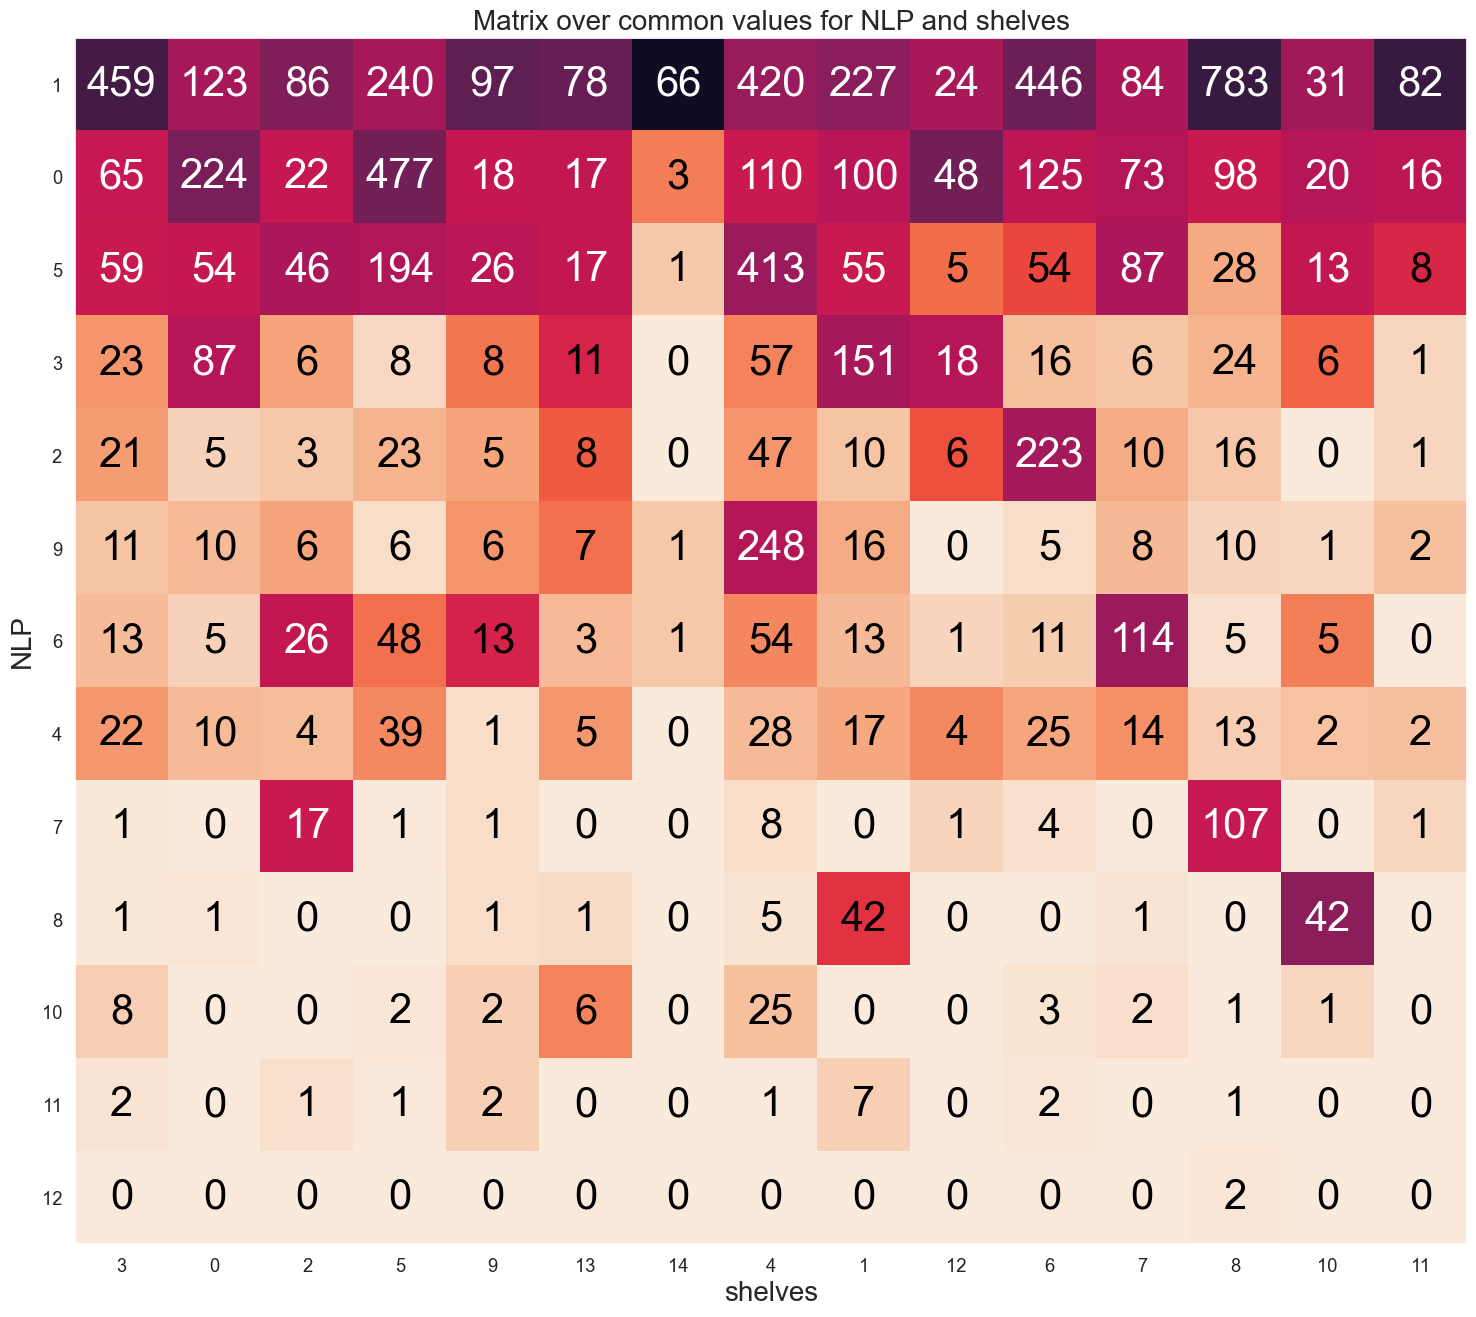

In [15]:
plot_matching_matrix(create_matching_matrix(graph_shelf_re,graph_NLp_re), title = "Matrix over common values for NLP and shelves", xlabel = "shelves", ylabel = "NLP",size_title = 20)

C:\Users\Sebastian\AppData\Local\Temp\ipykernel_59736\3355676211.py:17: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (col_name, col_data) in enumerate(matching_matrix.iteritems()):


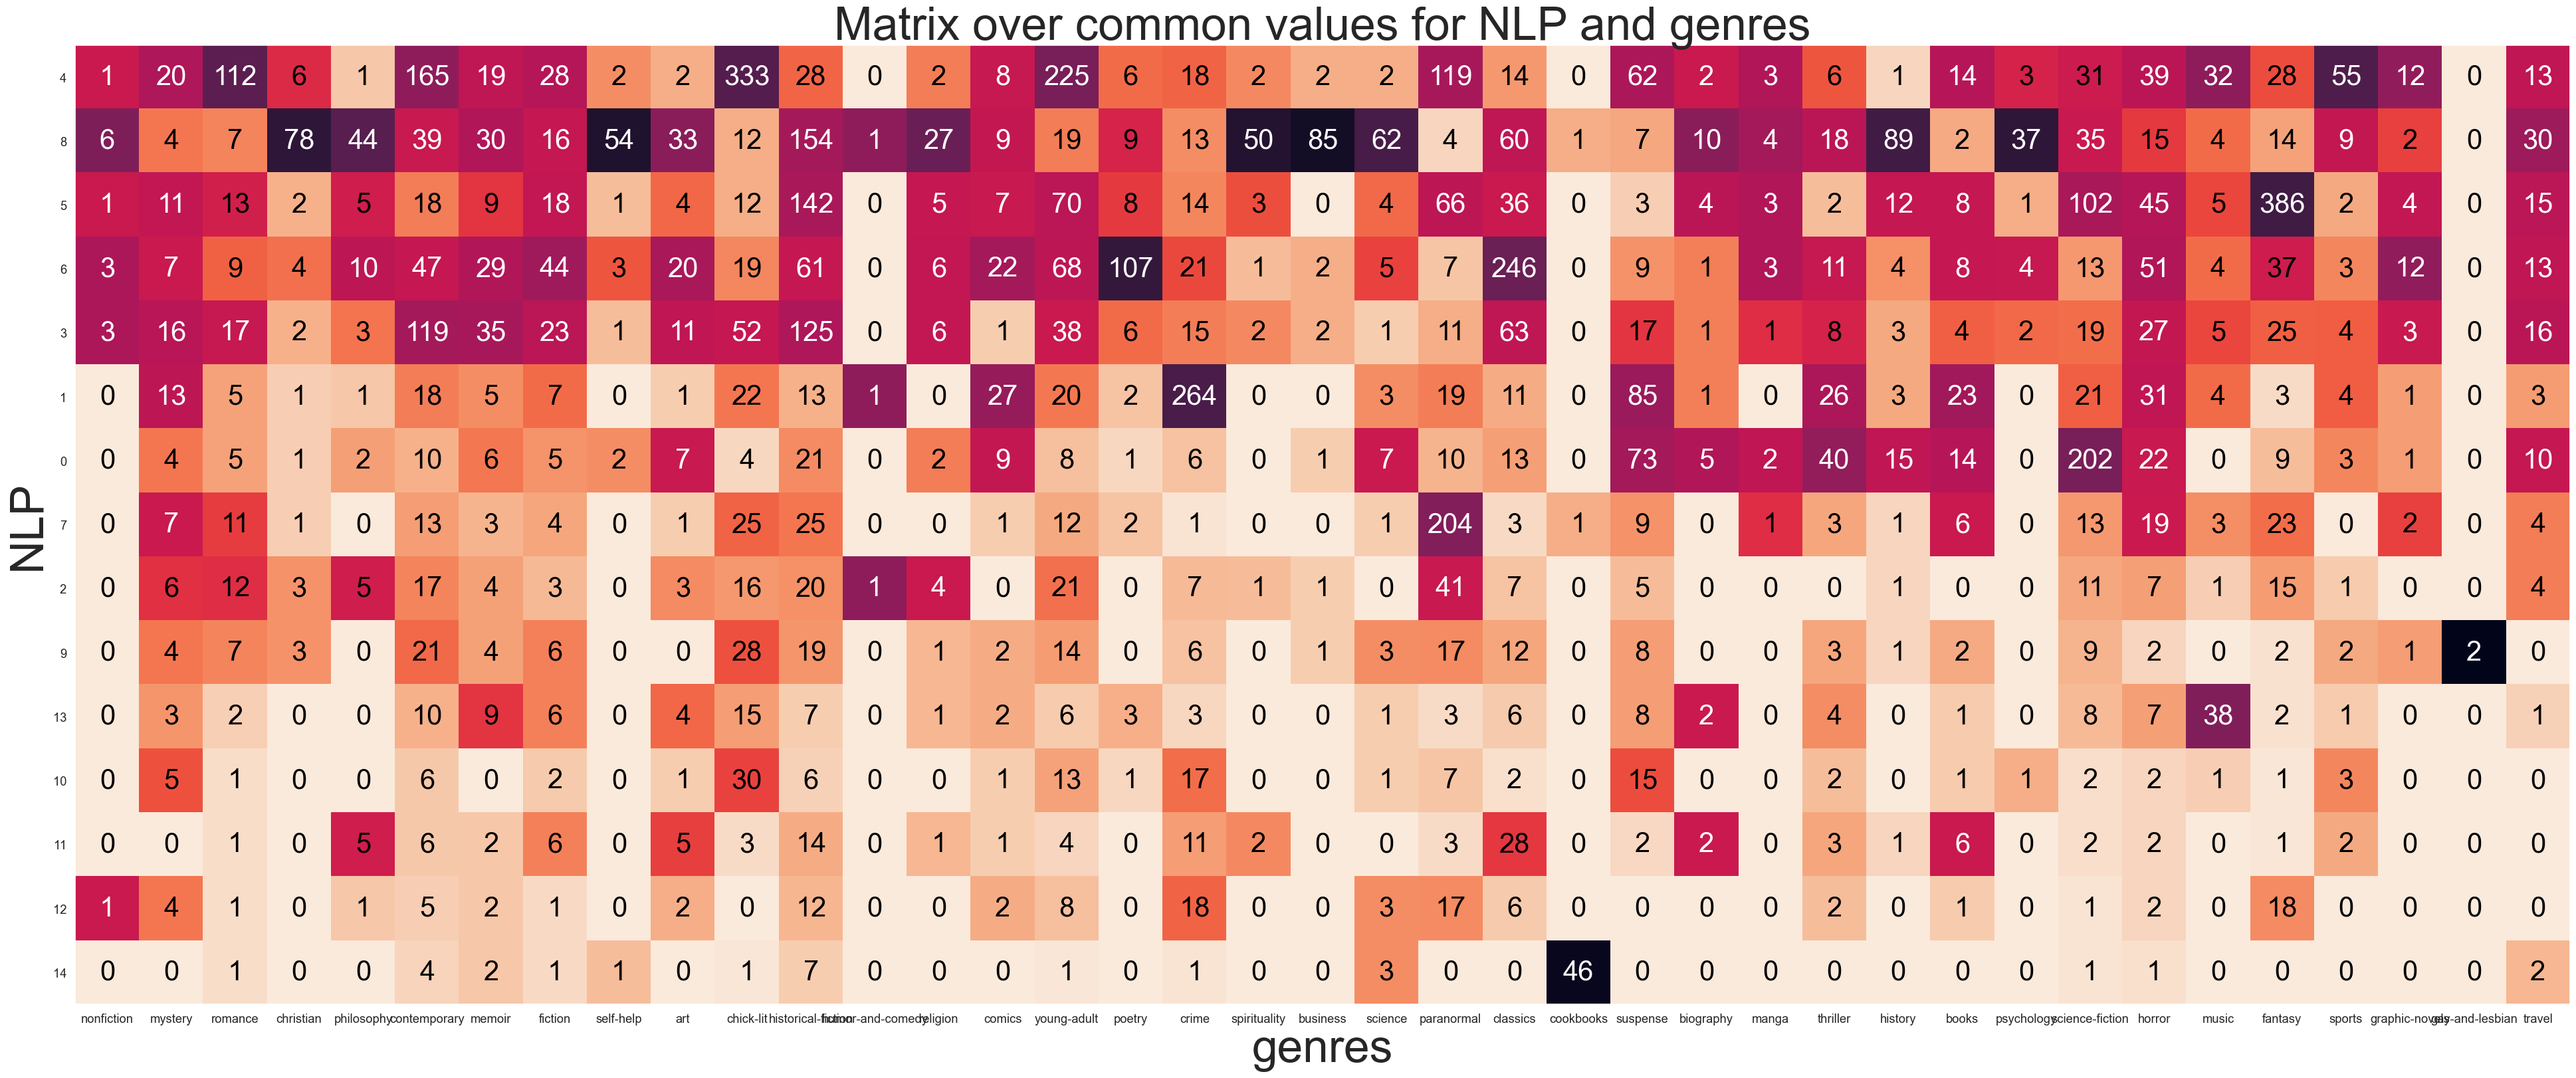

In [9]:
plot_matching_matrix(create_matching_matrix(graph_NLp_re,book_genre_dict), title = "Matrix over common values for NLP and genres", xlabel = "genres", ylabel = "NLP",size_title = 50)

C:\Users\Sebastian\AppData\Local\Temp\ipykernel_59736\3355676211.py:17: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (col_name, col_data) in enumerate(matching_matrix.iteritems()):


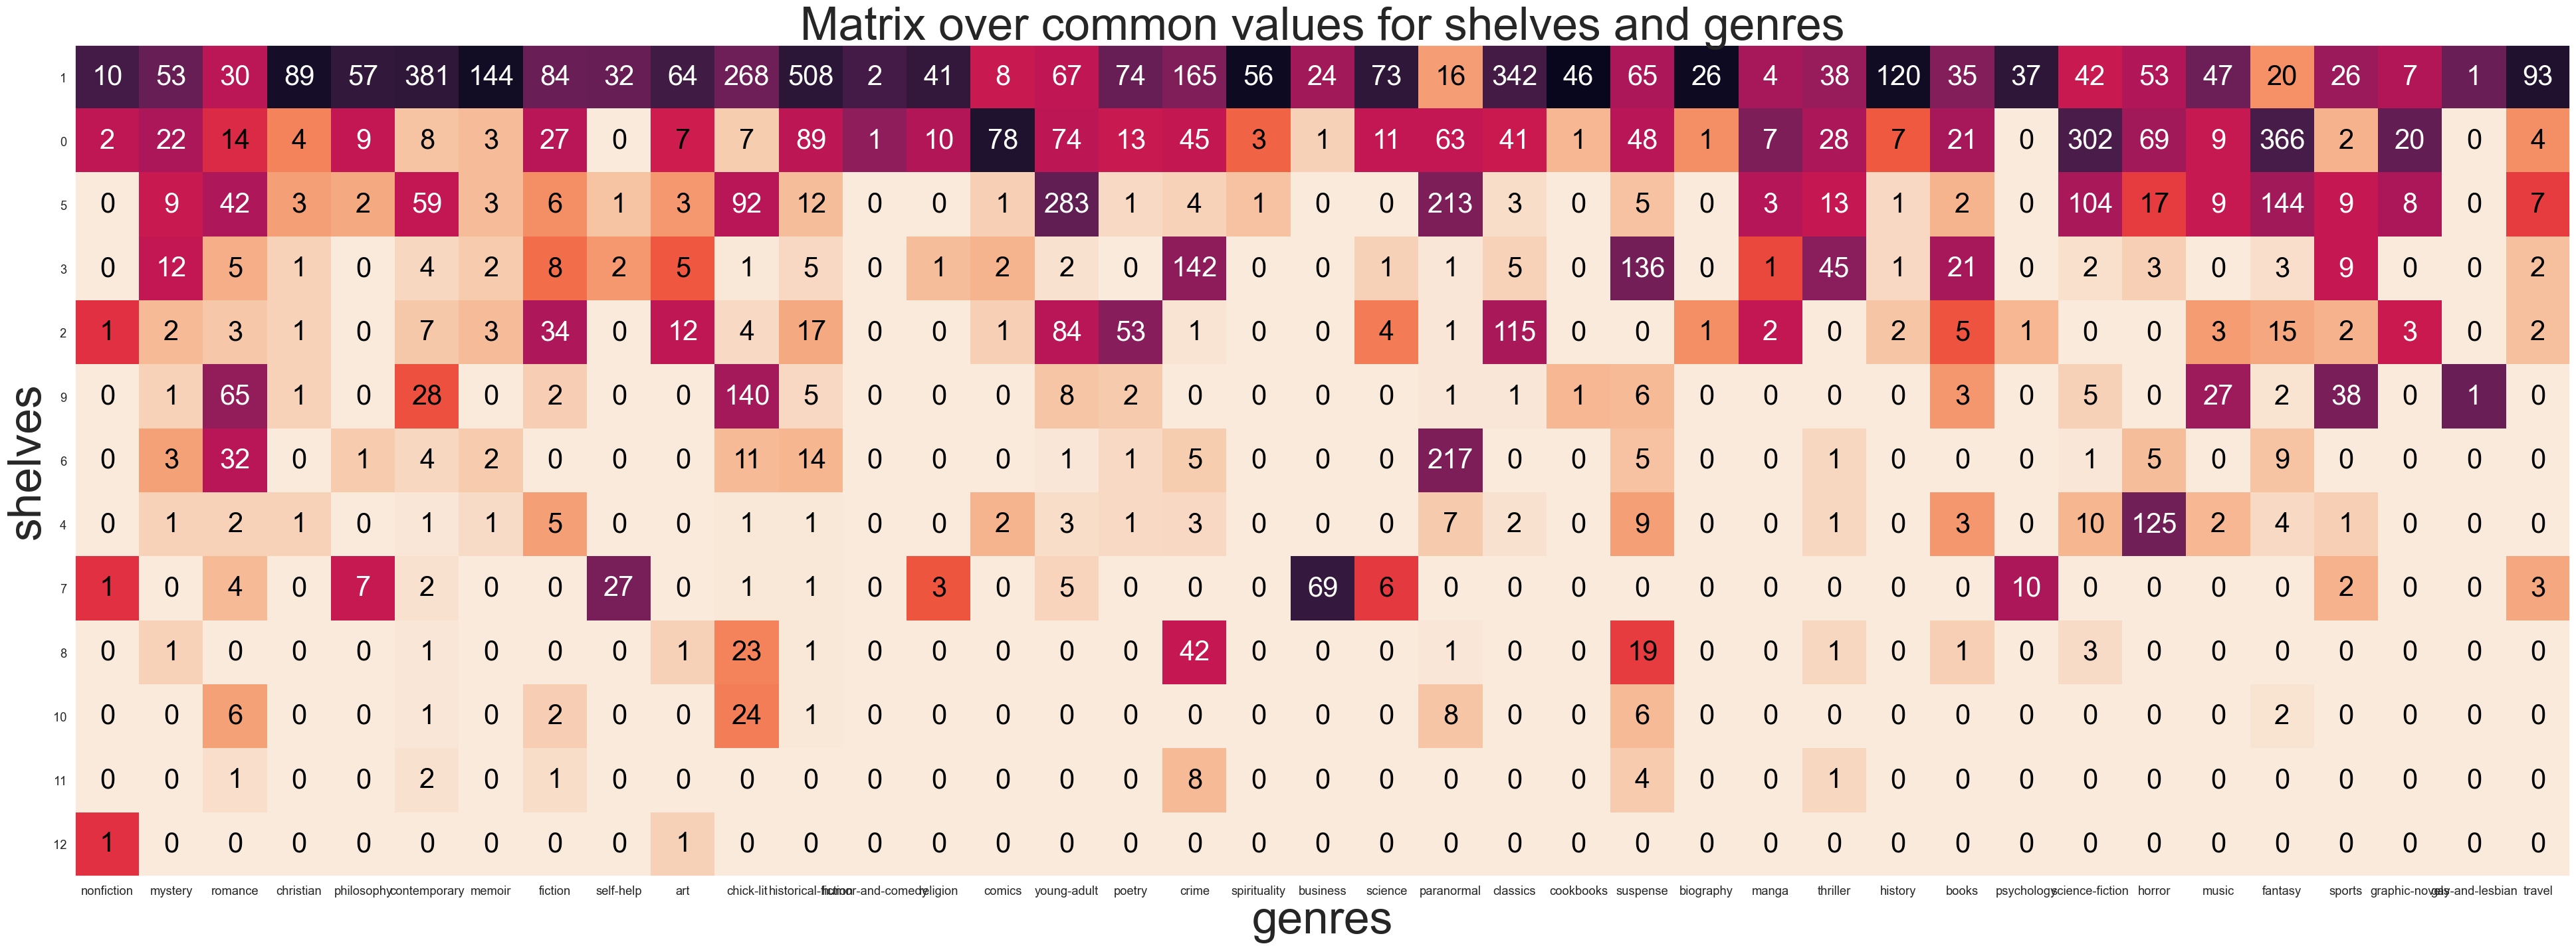

In [16]:
plot_matching_matrix(create_matching_matrix(graph_shelf_re,book_genre_dict), title = "Matrix over common values for shelves and genres", xlabel = "genres", ylabel = "shelves",size_title = 50)